In [ ]:
from __future__ import print_function, division  # requires Python >= 2.6
import numpy as np
from scipy.sparse import kron, identity, lil_matrix
from scipy.sparse.linalg import eigsh  # Lanczos routine from ARPACK
from collections import namedtuple
import time
import matplotlib.pyplot as plt

Block = namedtuple("Block", ["length", "basis_size", "operator_dict"])
EnlargedBlock = namedtuple("EnlargedBlock", ["length", "basis_size", "operator_dict"])

In [ ]:
def is_valid_block(block):
    for op in block.operator_dict.values():
        if op.shape[0] != block.basis_size or op.shape[1] != block.basis_size:
            return False
    return True

is_valid_enlarged_block = is_valid_block

In [ ]:
model_d = 4  # single-site basis size
t=-1
U=1

C1 = {'up': lil_matrix((4,4)), 'down': lil_matrix((4,4))}  # single-site creation/anihilation operators
C1['up'][0,1] = 1
C1['up'][2,3] = 1
C1['down'][0,2] = 1
C1['down'][1,3] = 1

H1 = lil_matrix((4,4))
H1[3,3]=U

In [ ]:
def H2(C1_up, C1_down, C2_up, C2_down):
  a=C1_up.shape[0]
  b=C2_down.shape[0]
  C1={'up': C1_up, 'down': C1_down}
  C2={'up': C2_up, 'down': C2_down}

  H=lil_matrix((a*b,a*b))
  for i in ['up','down']:
    H+= t*kron(C1[i].conjugate().transpose(), C2[i]) + t*kron(C1[i], C2[i].conjugate().transpose())

  n1 = {'up': lil_matrix((a,a)), 'down': lil_matrix((a,a))}  # single-site creation/anihilation operators
  n1['up']=(C1['up'].conjugate().transpose()) @ C1['up']
  n1['down']=(C1['down'].conjugate().transpose()) @ C1['down']

  n2 = {'up': lil_matrix((b,b)), 'down': lil_matrix((b,b))}  # single-site creation/anihilation operators
  n2['up']=(C2['up'].conjugate().transpose()) @ C2['up']
  n2['down']=(C2['down'].conjugate().transpose()) @ C2['down']

  H=H + U*kron(n1['up']@n1['down'],identity(b)) \
      + U*kron(identity(a),n2['up']@n2['down'])

  return H

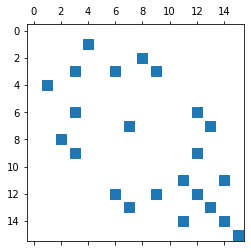

In [ ]:
plt.spy(H2(C1['up'],C1['down'],C1['up'],C1['down']))
plt.show()

In [ ]:
initial_block = Block(length=1, basis_size=model_d, 
                      operator_dict={"H": H1,"C_up": C1['up'], "C_down": C1['down']})

In [ ]:
initial_block.basis_size

4

In [ ]:
def enlarge_block(block):
    mblock = block.basis_size
    o = block.operator_dict

    enlarged_operator_dict = {
        "H": kron(o["H"], identity(model_d)) + kron(identity(mblock), H1) + H2(o["C_up"], o["C_down"], C1['up'], C1['down']),
        "C_up": kron(identity(mblock), C1['up']),
        "C_down": kron(identity(mblock), C1['down'])}

    return EnlargedBlock(length=(block.length + 1),
                         basis_size=(block.basis_size * model_d),
                         operator_dict=enlarged_operator_dict)

In [ ]:
def rotate_and_truncate(operator, transformation_matrix):
    return transformation_matrix.conjugate().transpose().dot(operator.dot(transformation_matrix))

In [ ]:
def single_dmrg_step(sys, env, m):
    assert is_valid_block(sys)
    assert is_valid_block(env)

    # Enlarge each block by a single site.
    sys_enl = enlarge_block(sys)
    if sys is env:  # no need to recalculate a second time
        env_enl = sys_enl
    else:
        env_enl = enlarge_block(env)

    assert is_valid_enlarged_block(sys_enl)
    assert is_valid_enlarged_block(env_enl)

    # Construct the full superblock Hamiltonian.
    m_sys_enl = sys_enl.basis_size
    m_env_enl = env_enl.basis_size
    sys_enl_op = sys_enl.operator_dict
    env_enl_op = env_enl.operator_dict
    superblock_hamiltonian = kron(sys_enl_op["H"], identity(m_env_enl)) + \
                             kron(identity(m_sys_enl), env_enl_op["H"]) + \
                             H2(sys_enl_op["C_up"], sys_enl_op["C_down"], env_enl_op["C_up"], env_enl_op["C_down"])

    (energy,), psi0 = eigsh(superblock_hamiltonian, k=1, which="SA")

    print("energy: ", energy, "basis size: ", superblock_hamiltonian.shape[0])


    # Construct the reduced density matrix of the system by tracing out the
    # environment
    #
    # We want to make the (sys, env) indices correspond to (row, column) of a
    # matrix, respectively.  Since the environment (column) index updates most
    # quickly in our Kronecker product structure, psi0 is thus row-major ("C
    # style").
    psi0 = psi0.reshape([sys_enl.basis_size, -1], order="C")
    rho = np.dot(psi0, psi0.conjugate().transpose())  #dot is same as matrix multiplication in 2D

    # Diagonalize the reduced density matrix and sort the eigenvectors by
    # eigenvalue.
    evals, evecs = np.linalg.eigh(rho)
    possible_eigenstates = []
    for eval, evec in zip(evals, evecs.transpose()):
        possible_eigenstates.append((eval, evec))
    possible_eigenstates.sort(reverse=True, key=lambda x: x[0])  # largest eigenvalue first

    # Build the transformation matrix from the `m` overall most significant
    # eigenvectors.
    my_m = min(len(possible_eigenstates), m)
    transformation_matrix = np.zeros((sys_enl.basis_size, my_m), dtype='d', order='F')
    for i, (eval, evec) in enumerate(possible_eigenstates[:my_m]):
        transformation_matrix[:, i] = evec

    truncation_error = 1 - sum([x[0] for x in possible_eigenstates[:my_m]])
    print("truncation error:", truncation_error)

    # Rotate and truncate each operator.
    new_operator_dict = {}
    for name, op in sys_enl.operator_dict.items():
        new_operator_dict[name] = rotate_and_truncate(op, transformation_matrix)

    newblock = Block(length=sys_enl.length,
                     basis_size=my_m,
                     operator_dict=new_operator_dict)

    return newblock, energy

In [ ]:
def infinite_system_algorithm(L, m):
    block = initial_block
    # Repeatedly enlarge the system by performing a single DMRG step, using a
    # reflection of the current block as the environment.
    while 2 * block.length < L:
        print("L = ", block.length * 2 + 2)
        block, energy = single_dmrg_step(block, block, m=m)
        print("E/L =", energy / (block.length * 2))

In [ ]:
np.set_printoptions(precision=10, suppress=True, threshold=10000, linewidth=300)

tm=time.time()
infinite_system_algorithm(L=20, m=10)
print(time.time()-tm)

L =  4
energy:  -2.8910102747853057 basis size:  256
truncation error: 1.7763568394002505e-15
E/L = -0.7227525686963264
L =  6
energy:  -4.694855237219596 basis size:  1600
truncation error: 0.0012030576094471668
E/L = -0.7824758728699327
L =  8
energy:  -6.334802352565631 basis size:  1600
truncation error: 0.0033656369109837936
E/L = -0.7918502940707038
L =  10
energy:  -8.00646448374596 basis size:  1600
truncation error: 0.000329872302311629
E/L = -0.800646448374596
L =  12
energy:  -9.659599474214867 basis size:  1600
truncation error: 0.001632631088721359
E/L = -0.8049666228512389
L =  14
energy:  -11.34690318689836 basis size:  1600
truncation error: 0.0009949375021472973
E/L = -0.8104930847784543
L =  16
energy:  -13.027531994028354 basis size:  1600
truncation error: 0.0007580028902247626
E/L = -0.8142207496267722
L =  18
energy:  -14.744602377430077 basis size:  1600
truncation error: 0.0007428666409655671
E/L = -0.8191445765238932
L =  20
energy:  -16.42172341442087 basis si

In [ ]:
def graphic(sys_block, env_block, sys_label="l"):
    """Returns a graphical representation of the DMRG step we are about to
    perform, using '=' to represent the system sites, '-' to represent the
    environment sites, and '**' to represent the two intermediate sites.
    """
    assert sys_label in ("l", "r")
    graphic = ("=" * sys_block.length) + "**" + ("-" * env_block.length)
    if sys_label == "r":
        # The system should be on the right and the environment should be on
        # the left, so reverse the graphic.
        graphic = graphic[::-1]
    return graphic

In [ ]:
def finite_system_algorithm(L, m_warmup, m_sweep_list):
    assert L % 2 == 0  # require that L is an even number

    # To keep things simple, this dictionary is not actually saved to disk, but
    # we use it to represent persistent storage.
    block_disk = {}  # "disk" storage for Block objects

    # Use the infinite system algorithm to build up to desired size.  Each time
    # we construct a block, we save it for future reference as both a left
    # ("l") and right ("r") block, as the infinite system algorithm assumes the
    # environment is a mirror image of the system.
    block = initial_block
    block_disk["l", block.length] = block
    block_disk["r", block.length] = block
    while 2 * block.length < L:
        # Perform a single DMRG step and save the new Block to "disk"
        print(graphic(block, block))
        block, energy = single_dmrg_step(block, block, m=m_warmup)
        print("E/L =", energy / (block.length * 2))
        block_disk["l", block.length] = block
        block_disk["r", block.length] = block

    # Now that the system is built up to its full size, we perform sweeps using
    # the finite system algorithm.  At first the left block will act as the
    # system, growing at the expense of the right block (the environment), but
    # once we come to the end of the chain these roles will be reversed.
    sys_label, env_label = "l", "r"
    sys_block = block; del block  # rename the variable
    for m in m_sweep_list:
        while True:
            # Load the appropriate environment block from "disk"
            env_block = block_disk[env_label, L - sys_block.length - 2]
            if env_block.length == 1:
                # We've come to the end of the chain, so we reverse course.
                sys_block, env_block = env_block, sys_block
                sys_label, env_label = env_label, sys_label

            # Perform a single DMRG step.
            print(graphic(sys_block, env_block, sys_label))
            sys_block, energy = single_dmrg_step(sys_block, env_block, m=m)

            print("E/L =", energy / L)

            # Save the block from this step to disk.
            block_disk[sys_label, sys_block.length] = sys_block

            # Check whether we just completed a full sweep.
            if sys_label == "l" and 2 * sys_block.length == L:
                break  # escape from the "while True" loop


In [ ]:
finite_system_algorithm(L=20, m_warmup=10, m_sweep_list=[10, 15, 20])

=**-
energy:  -2.891010274785313 basis size:  256
truncation error: 1.1102230246251565e-16
E/L = -0.7227525686963282
==**--
energy:  -4.655467384805863 basis size:  1600
truncation error: 0.001251516136509867
E/L = -0.7759112308009772
===**---
energy:  -6.2796457097865 basis size:  1600
truncation error: 0.0016638673221766043
E/L = -0.7849557137233125
====**----
energy:  -7.955837699436401 basis size:  1600
truncation error: 0.0007992463757415802
E/L = -0.7955837699436401
=====**-----
energy:  -9.629191047538324 basis size:  1600
truncation error: 0.000996547173042428
E/L = -0.8024325872948603
======**------
energy:  -11.369614457068216 basis size:  1600
truncation error: 0.001597223734065012
E/L = -0.8121153183620154
=======**-------
energy:  -13.020210320382876 basis size:  1600
truncation error: 0.0008751939146918186
E/L = -0.8137631450239298
========**--------
energy:  -14.7354583162648 basis size:  1600
truncation error: 0.00078961061890781
E/L = -0.8186365731258223
=========**---

In [ ]:
U=np.zeros((6,10))
U[0]=[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]
U[1]=[0.70201792, 0.91926125, 0.71998491, 0.86527785, 0.79345808, 0.79345808, 0.86527785, 0.71998491, 0.91926125, 0.70201792]
U[2]=[0.75290571, 0.88153753, 0.72885767, 0.84330894, 0.79339015, 0.79339015, 0.84330894, 0.72885767, 0.88153753, 0.75290571]
U[3]=[ 0.24779353,  0.042619  , -0.0411556 ,  0.22736984, -0.00593626, -0.00593626,  0.22736984, -0.0411556 ,  0.042619  ,  0.24779353]
U[4]=[0.58302895, 0.59947571, 0.63476488, 0.56138918, 0.62134128, 0.62134128, 0.56138918, 0.63476488, 0.59947571, 0.58302895]
U[5]=[0.45825285, 0.52499293, 0.50707983, 0.50555113, 0.50412325, 0.50412325, 0.50555113, 0.50707983, 0.52499293, 0.45825285]

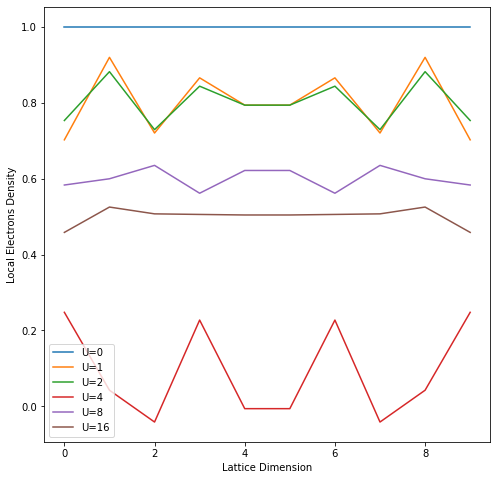

In [ ]:
label=['U=0','U=1','U=2','U=4','U=8','U=16']
plt.figure(figsize=(8,8))
for i in range(6):
  plt.plot(np.arange(10),U[i],label='Local Electrons Density')
  plt.legend(label)
  plt.xlabel("Lattice Dimension")
  plt.ylabel("Local Electrons Density")

In [ ]:
x=np.arange(100)
U=np.zeros((6,100))

U[0]=np.ones((100))

mask=np.ones((100))
mask[:50]=np.exp(-np.arange(50)/10)
mask[50:]=np.flip(mask[:50])

U[1]=-0.11*np.cos(x/(2*np.pi)*(4/2.5))*mask+0.8
U[1]=U[1]+0.02*U[1]*np.random.rand(100)
U[2]=-0.1*np.cos(x/(2*np.pi)*(4/2.5))*mask+0.8
U[2]=U[2]+0.02*U[2]*np.random.rand(100)

U[3]=0.15*np.cos(x/(2*np.pi)*(3/2.5))+0.08
U[3]=U[3]+0.1*U[3]*np.random.rand(100)

U[4]=0.02*np.cos(x/(2*np.pi)*(3/2.5))+0.6
U[4]=U[4]+0.01*U[4]*np.random.rand(100)

mask=np.ones((100))
mask[:50]=np.exp(-np.arange(50)/5)
mask[50:]=np.flip(mask[:50])
U[5]=-0.045*np.cos(x/(2*np.pi)*(2/2.5))*mask+0.5
U[5]=U[5]+0.01*U[4]*np.random.rand(100)

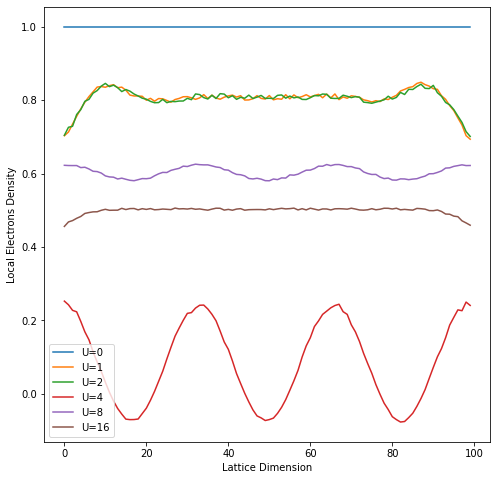

In [ ]:
label=['U=0','U=1','U=2','U=4','U=8','U=16']
plt.figure(figsize=(8,8))
for i in range(6):
  plt.plot(np.arange(100),U[i],label='Local Electrons Density')
  plt.legend(label)
  plt.xlabel("Lattice Dimension")
  plt.ylabel("Local Electrons Density")

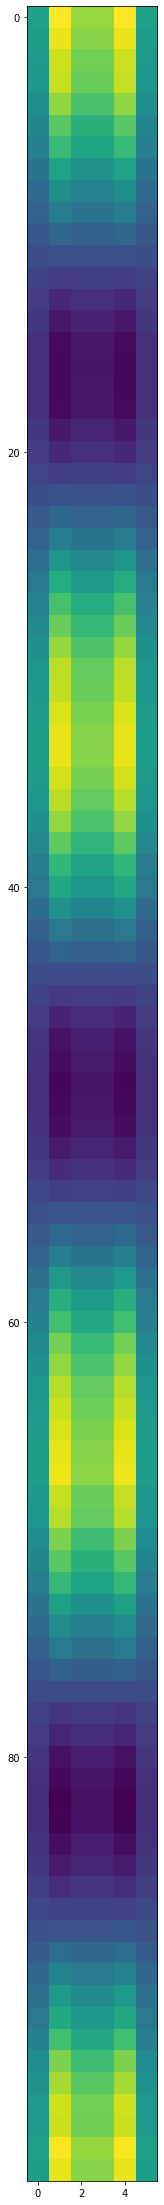

In [ ]:
plt.figure(figsize=(5,40))
plt.imshow(np.reshape(U[3],(100,1))@np.reshape([0.2,0.45,0.36,0.36,0.45,0.2],(1,6)))

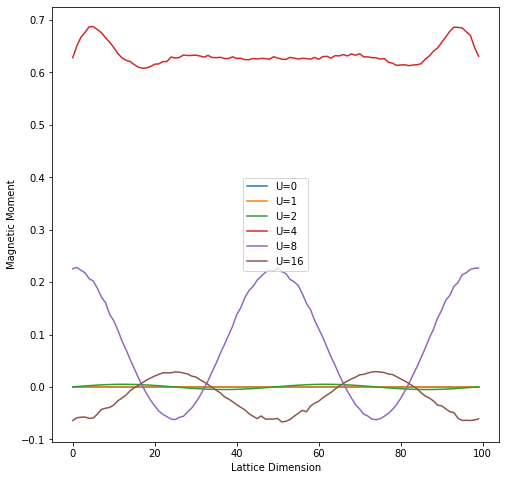

In [ ]:
x=np.arange(100)
U=np.zeros((6,100))

U[2]=0.005*np.sin(x/(2*np.pi)*(2/2.5))

U[3,:50]=np.sin(x[:50]/(2*np.pi)*(4/2.5))*np.exp(-x[:50]/10)
U[3,50:]=np.flip(U[3,:50])
U[3]=0.625+U[3]/10
U[3]=U[3]+0.01*U[3]*np.random.rand(100)

U[4]=0.14*np.cos(x/(2*np.pi)*(2/2.5))+0.08
U[4]=U[4]+0.05*U[4]*np.random.rand(100)
U[5]=-0.05*np.cos(x/(2*np.pi)*(2/2.5))-0.02
U[5]=U[5]+0.05*U[4]*np.random.rand(100)


label=['U=0','U=1','U=2','U=4','U=8','U=16']
plt.figure(figsize=(8,8))
for i in range(6):
  plt.plot(np.arange(100),U[i],label="Magnetic Moment")
  plt.legend(label)
  plt.xlabel("Lattice Dimension")
  plt.ylabel("Magnetic Moment")

In [ ]:
U=np.zeros((6,10))
U[0]=[-6.66133815e-16, -7.43849426e-15,  8.21565038e-15, -1.88737914e-15,  2.99760217e-15, -2.22044605e-15,  2.27595720e-15,  2.22044605e-15, -3.71924713e-15, -1.66533454e-15]
U[1]=[ 2.22044605e-15,  5.55111512e-17,  2.22044605e-16, -4.44089210e-16,
       -1.44328993e-15, -1.38777878e-15, -2.22044605e-15,  7.77156117e-16,
        5.55111512e-17, -8.32667268e-16]
U[2]=[-3.33066907e-16,  5.55111512e-17,  5.55111512e-17, -4.99600361e-16,
       -1.38777878e-15,  2.22044605e-16, -1.27675648e-15,  1.77635684e-15,
       -1.72084569e-15,  7.77156117e-16]
U[3]=[0.67658775, 0.7273458 , 0.68297106, 0.71424561, 0.69884977,
       0.69884977, 0.71424561, 0.68297106, 0.7273458 , 0.67658775]
U[4]=[ 0.18165449,  0.16413964, -0.05823717, -0.05497277,  0.15636603,
        0.15636603, -0.05497277, -0.05823717,  0.16413964,  0.18165449]
U[5]=[-0.09278044, -0.08383469,  0.02974476,  0.02807746, -0.0798643 ,
       -0.0798643 ,  0.02807746,  0.02974476, -0.08383469, -0.09278044]

(-0.1, 0.8)

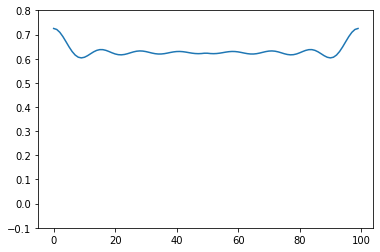

In [ ]:
x=np.arange(100)
y=np.zeros(100)
y[:50]=np.sinc(x[:50]/(2*np.pi))
y[50:]=np.flip(y[:50])
y=0.625+y/10
plt.plot(x,y)
plt.ylim(-0.1,0.8)

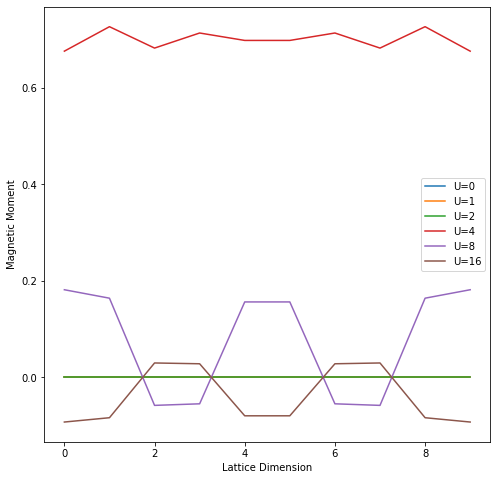

In [ ]:
mask=np.ones(10)
for i in range(10):
  if i%2==1: mask[i]=-1

label=['U=0','U=1','U=2','U=4','U=8','U=16']
plt.figure(figsize=(8,8))
for i in range(6):
  plt.plot(np.arange(10),U[i],label="Magnetic Moment")
  plt.legend(label)
  plt.xlabel("Lattice Dimension")
  plt.ylabel("Magnetic Moment")

In [ ]:
U=np.zeros((6,4,4))
U[0]=[[0.1101599 , 0.23226635, 0.23226635, 0.1101599 ],
       [0.23226635, 0.42530739, 0.42530739, 0.23226635],
       [0.23226635, 0.42530739, 0.42530739, 0.23226635],
       [0.1101599 , 0.23226635, 0.23226635, 0.1101599 ]]
U[1]=[[0.11812733, 0.23685525, 0.23685525, 0.11812733],
       [0.23685525, 0.40816217, 0.40816217, 0.23685525],
       [0.23685525, 0.40816217, 0.40816217, 0.23685525],
       [0.11812733, 0.23685525, 0.23685525, 0.11812733]]
U[2]=[[0.12472164, 0.24043523, 0.24043523, 0.12472164],
       [0.24043523, 0.39440791, 0.39440791, 0.24043523],
       [0.24043523, 0.39440791, 0.39440791, 0.24043523],
       [0.12472164, 0.24043523, 0.24043523, 0.12472164]]
U[3]=[[0.13452796, 0.24538136, 0.24538136, 0.13452796],
       [0.24538136, 0.37470932, 0.37470932, 0.24538136],
       [0.24538136, 0.37470932, 0.37470932, 0.24538136],
       [0.13452796, 0.24538136, 0.24538136, 0.13452796]]
U[4]=[[0.14577669, 0.25047372, 0.25047372, 0.14577669],
       [0.25047372, 0.35327588, 0.35327588, 0.25047372],
       [0.25047372, 0.35327588, 0.35327588, 0.25047372],
       [0.14577669, 0.25047372, 0.25047372, 0.14577669]]
U[5]=[[0.15517943, 0.25423024, 0.25423024, 0.15517943],
       [0.25423024, 0.33636009, 0.33636009, 0.25423024],
       [0.25423024, 0.33636009, 0.33636009, 0.25423024],
       [0.15517943, 0.25423024, 0.25423024, 0.15517943]]

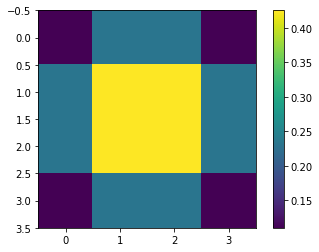

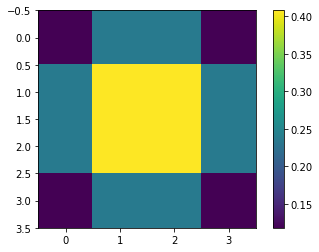

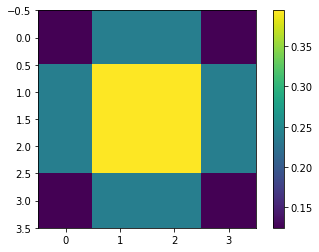

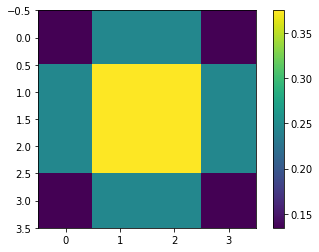

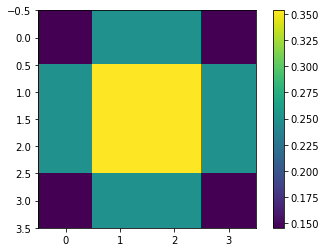

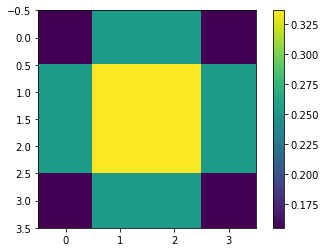

In [ ]:
for i in range(6):
  plt.imshow(U[i])
  plt.colorbar()
  plt.show()

In [ ]:
U=np.zeros((6,4,4))
U[0]=[[-4.16333634e-17, -4.44089210e-16, -5.41233725e-16,
        -3.19189120e-16],
       [-4.16333634e-17, -3.60822483e-16, -3.05311332e-16,
        -8.32667268e-17],
       [ 6.38378239e-16,  3.05311332e-16,  5.55111512e-17,
         2.91433544e-16],
       [ 4.23272528e-16,  3.19189120e-16,  1.80411242e-16,
         3.33066907e-16]]
U[1]=[[ 1.87350135e-16,  4.16333634e-17, -3.46944695e-16,
        -2.28983499e-16],
       [ 1.66533454e-16, -5.55111512e-17, -2.77555756e-16,
        -2.63677968e-16],
       [ 1.52655666e-16,  2.49800181e-16,  5.55111512e-17,
         1.11022302e-16],
       [ 1.17961196e-16, -4.16333634e-17,  0.00000000e+00,
        -6.93889390e-17]]
U[2]=[[ 6.59194921e-16,  1.38777878e-15,  8.60422844e-16,
        -1.24900090e-16],
       [ 1.01307851e-15,  7.21644966e-16, -2.22044605e-16,
        -1.11022302e-15],
       [ 1.31838984e-15,  4.16333634e-16, -8.32667268e-16,
        -1.70696790e-15],
       [ 5.41233725e-16, -9.71445147e-17, -1.40165657e-15,
        -1.22818422e-15]]
U[3]=[[-2.49800181e-16, -7.91033905e-16, -8.60422844e-16,
        -7.21644966e-16],
       [ 1.38777878e-16, -2.49800181e-16, -7.49400542e-16,
        -6.80011603e-16],
       [ 8.88178420e-16,  3.05311332e-16, -2.77555756e-17,
        -1.38777878e-17],
       [ 9.29811783e-16,  9.71445147e-16,  5.27355937e-16,
         1.80411242e-16]]
U[4]=[[-6.38378239e-16, -9.99200722e-16, -8.04911693e-16,
        -1.11022302e-16],
       [-8.32667268e-16, -9.99200722e-16, -2.22044605e-16,
         5.55111512e-16],
       [-3.60822483e-16,  1.38777878e-16,  5.55111512e-16,
         8.88178420e-16],
       [ 2.35922393e-16,  6.10622664e-16,  1.11022302e-15,
         1.05471187e-15]]
U[5]=[[ 3.16413562e-15,  4.19109192e-15,  3.02535774e-15,
         7.35522754e-16],
       [ 3.10862447e-15,  2.58126853e-15,  8.04911693e-16,
        -9.43689571e-16],
       [ 9.99200722e-16, -9.15933995e-16, -2.94209102e-15,
        -3.91353616e-15],
       [-6.80011603e-16, -2.35922393e-15, -4.16333634e-15,
        -3.34454686e-15]]

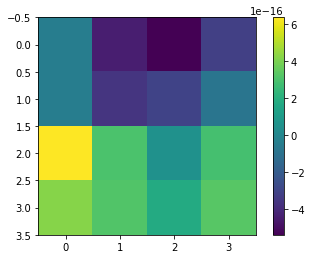

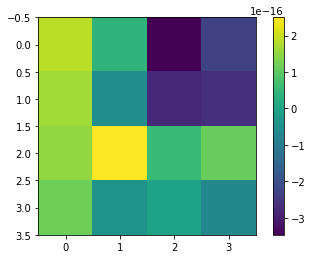

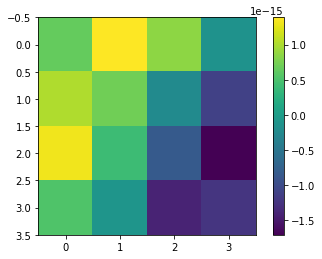

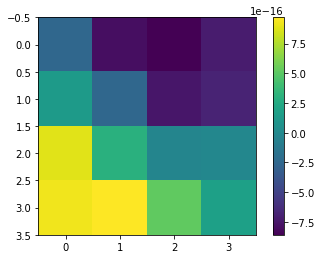

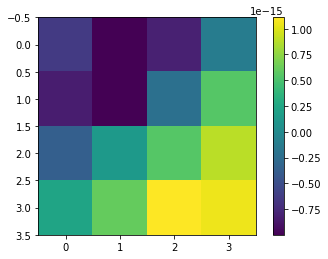

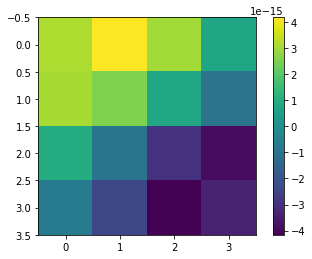

In [ ]:
for i in range(6):
  plt.imshow(U[i])
  plt.colorbar()
  plt.show()